In [57]:
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
import csv 
from matplotlib import colors as mcolors
import json
from scipy.stats import ttest_ind, f_oneway, tukey_hsd
from statsmodels.stats.multitest import fdrcorrection


In [2]:
#this is needed for the clustermap later
sys.setrecursionlimit(100000000)
ft = pd.read_csv("/Users/mitchjo/Projects/PythonCentricPipelineForMetabolomics/examples/Analyses/MSV_COVID/filtered_feature_tables/pref_for_analysis_Feature_table.tsv", sep="\t")
metadata = pd.read_csv("./s_MTBLS3852.csv")


In [3]:
# set up colors and associate samples with disease classes
colors = ['k', 'red', 'green', 'blue']
color_map = {}
stage_map = {}
color_index = 0
col_colors = []
sample_columns = []
for column in ft.columns[11:]:
    stage = metadata[metadata["Source Name"] == column]["Factor Value[Disease staging]"].values[0]
    if stage in ("control", "severe COVID-19", "post-acute COVID-19"):
        if stage not in color_map:
            color_map[stage]=colors[color_index]
            color_index += 1
        col_colors.append(color_map[stage])
        sample_columns.append(column)
        stage_map[column] = stage

In [5]:
# extract values for stats

def __extract__(row, columns):
    return [row[c] for c in columns]
        
control_cols = [x for x, v in stage_map.items() if v == "control"]
severe_cols = [x for x, v in stage_map.items() if v == "severe COVID-19"]
post_cols = [x for x, v in stage_map.items() if v == "post-acute COVID-19"]

control_vals = ft.apply(__extract__, axis=1, args=(control_cols,))
severe_vals = ft.apply(__extract__, axis=1, args=(severe_cols,))
post_vals = ft.apply(__extract__, axis=1, args=(post_cols,))

In [9]:
# now perform stats and do multitest correction
raw_p_values = []
for c,s,p,f in zip(control_vals, severe_vals, post_vals, ft['id_number']):
    _, p = f_oneway(c, s, p)
    raw_p_values.append(p)
_, corr_p_values = fdrcorrection(raw_p_values)

omnibus = []
significant = []
sig_features = []
for corr_p, f_id in zip(corr_p_values, ft['id_number']):
    if corr_p < .05:
        sig_features.append(f_id)

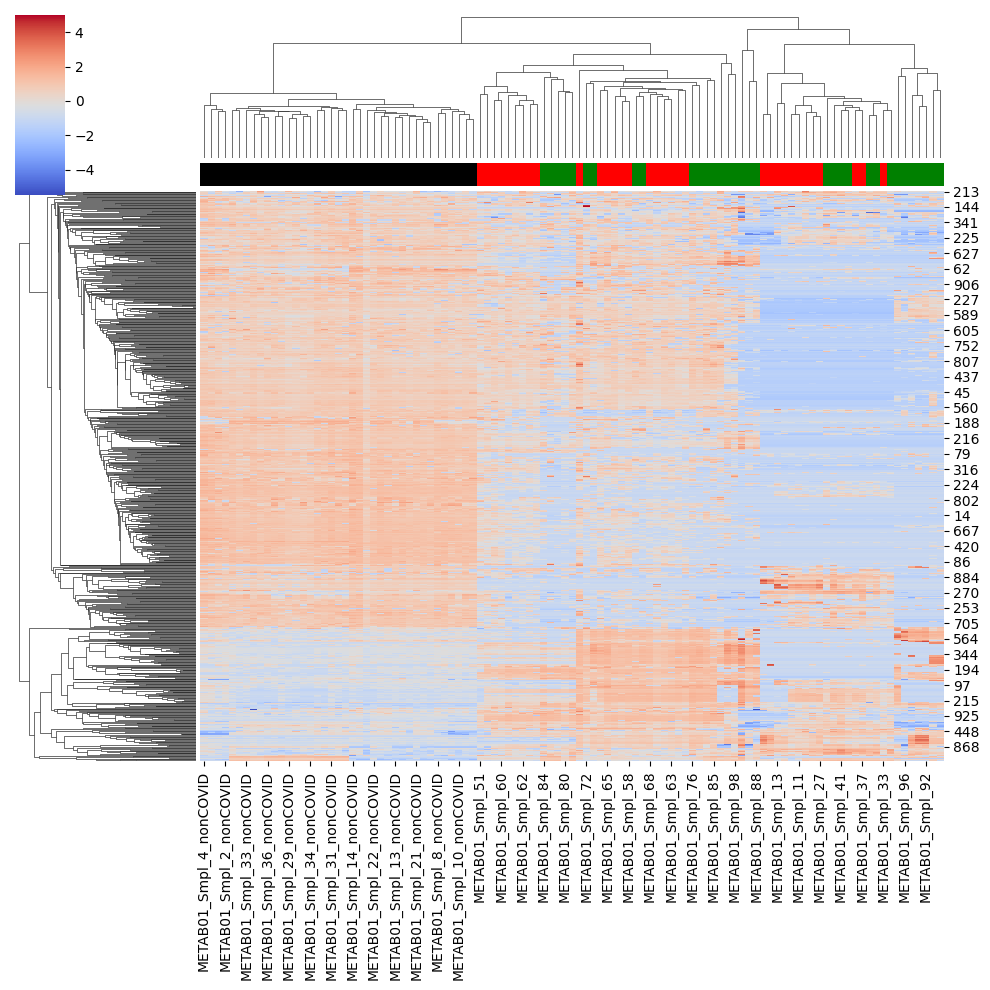

In [10]:
sns.clustermap(ft[ft["id_number"].isin(sig_features)][sample_columns], col_colors=col_colors, cmap='coolwarm', z_score=0)
plt.show()

[[1. 0.]
 [0. 1.]]
0.0
[[1. 0.]
 [0. 1.]]
0.0
[[1.         0.06885884]
 [0.06885884 1.        ]]
0.06885884258602581


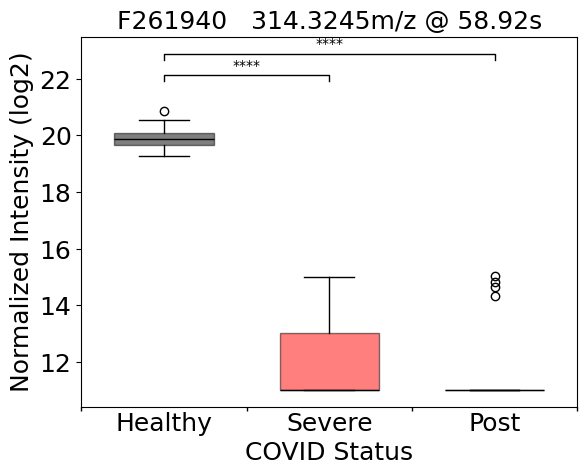

[[1. 0.]
 [0. 1.]]
0.0
[[1. 0.]
 [0. 1.]]
0.0
[[1.         0.25745819]
 [0.25745819 1.        ]]
0.257458185047964


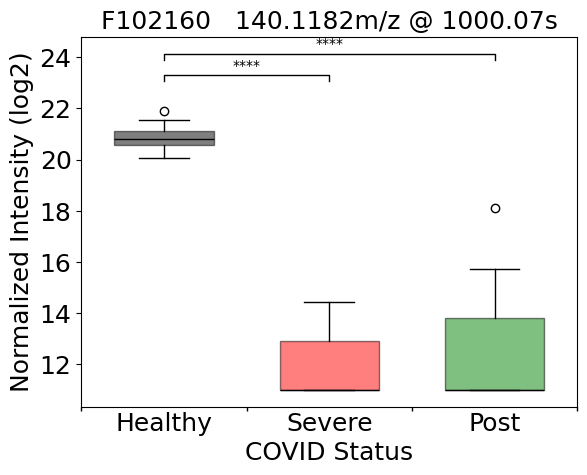

[[1. 0.]
 [0. 1.]]
0.0
[[1. 0.]
 [0. 1.]]
0.0
[[1.         0.20942146]
 [0.20942146 1.        ]]
0.2094214632978212


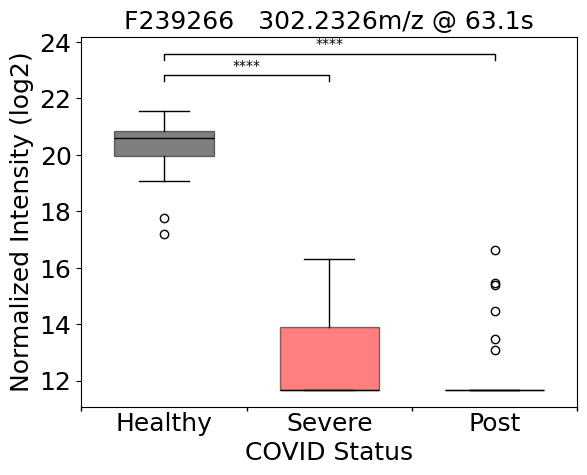

[[1. 0.]
 [0. 1.]]
0.0
[[1. 0.]
 [0. 1.]]
0.0
[[1.        0.2427258]
 [0.2427258 1.       ]]
0.2427258019776002


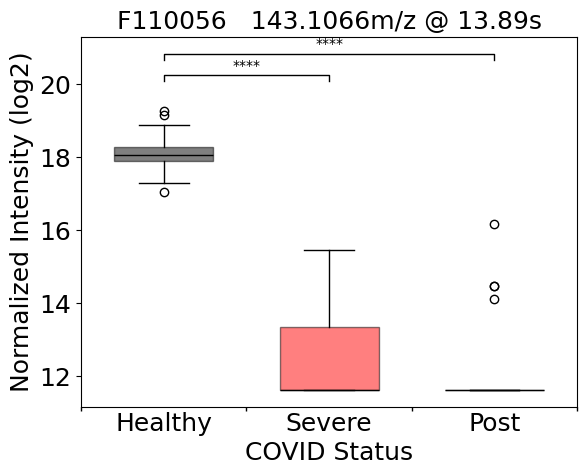

[[1. 0.]
 [0. 1.]]
0.0
[[1. 0.]
 [0. 1.]]
0.0
[[1.00000000e+00 1.81704122e-04]
 [1.81704122e-04 1.00000000e+00]]
0.00018170412181950368


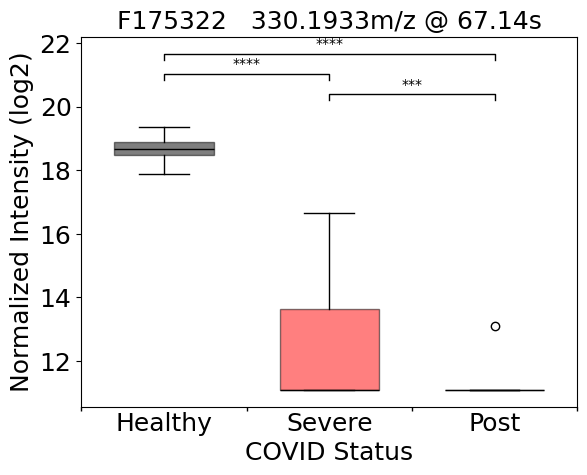

[[1. 0.]
 [0. 1.]]
0.0
[[1. 0.]
 [0. 1.]]
0.0
[[1.         0.02722833]
 [0.02722833 1.        ]]
0.027228325980014678


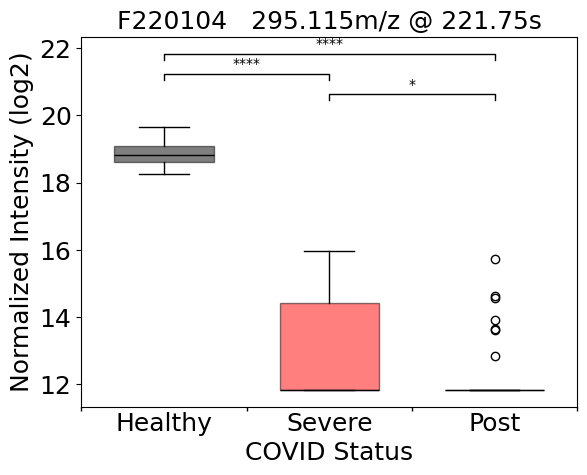

[[1. 0.]
 [0. 1.]]
0.0
[[1. 0.]
 [0. 1.]]
0.0
[[1.00000000e+00 7.30430667e-05]
 [7.30430667e-05 1.00000000e+00]]
7.304306672106797e-05


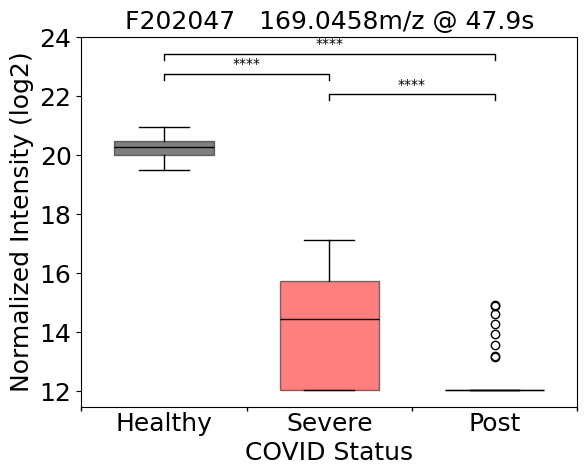

[[1. 0.]
 [0. 1.]]
0.0
[[1. 0.]
 [0. 1.]]
0.0
[[1.0000000e+00 2.7025544e-04]
 [2.7025544e-04 1.0000000e+00]]
0.00027025544035264026


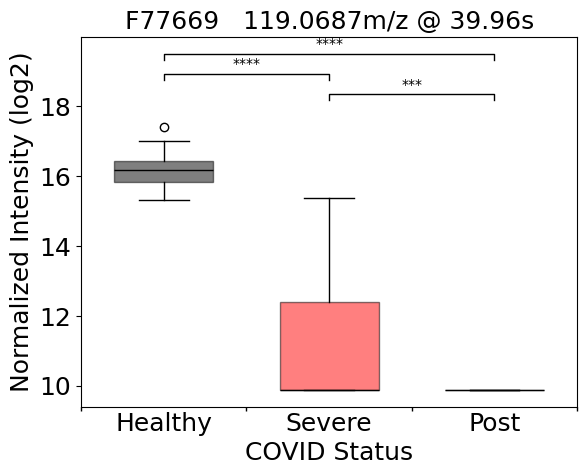

[[1. 0.]
 [0. 1.]]
0.0
[[1. 0.]
 [0. 1.]]
0.0
[[1.         0.07415946]
 [0.07415946 1.        ]]
0.0741594557856109


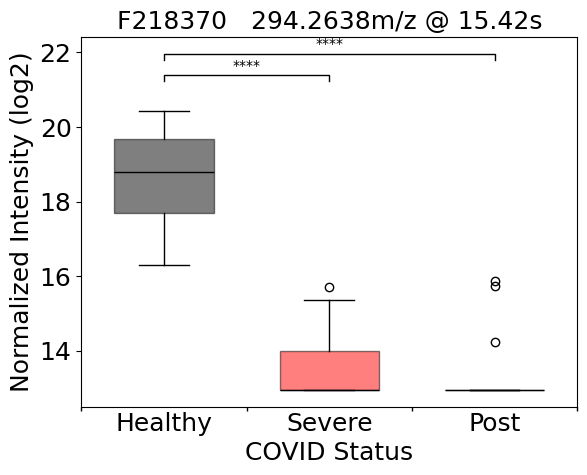

[[1. 0.]
 [0. 1.]]
0.0
[[1. 0.]
 [0. 1.]]
0.0
[[1.0000000e+00 2.7988023e-06]
 [2.7988023e-06 1.0000000e+00]]
2.7988023019176467e-06


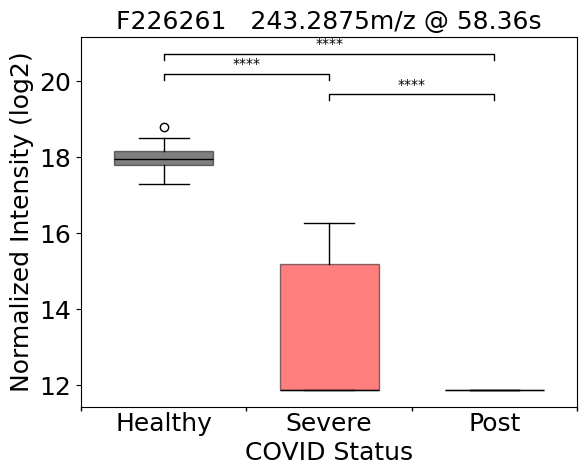

In [71]:
# box plots
from scipy.stats import mannwhitneyu
p_f_id_tuples = sorted([x for x in zip(corr_p_values, ft['id_number'])], key=lambda x: x[0])
for i in range(10):
    top_feature = p_f_id_tuples[i][1]
    subset = ft[ft['id_number'] == top_feature]
    mz = subset['mz'].values[0]
    rtime = subset['rtime'].values[0]
    subset_control_vals = subset[control_cols].values[0]
    subset_severe_vals = subset[severe_cols].values[0]
    subset_post_vals = subset[post_cols].values[0]
    data = [subset_control_vals, subset_severe_vals, subset_post_vals]

    ax = plt.axes()
    # Create a boxplot on the axes
    bp = ax.boxplot(data, widths=0.6, patch_artist=True)
    # Graph title
    ax.set_title(top_feature + "   " + str(round(mz,4)) + "m/z @ " + str(rtime) + 's', fontsize=18)
    # Label y-axis
    ax.set_ylabel(r'Petal Length, $L$ / cm')
    # Label x-axis ticks
    xticklabels = ["Healthy", "Severe", "Post"]
    ax.set_xticklabels(xticklabels, fontsize=18)
    # Hide x-axis major ticks
    ax.tick_params(axis='x', which='major', length=0)
    # Show x-axis minor ticks
    xticks = [0.5] + [x + 0.5 for x in ax.get_xticks()]
    ax.set_xticks(xticks, minor=True)
    # Clean up the appearance
    ax.tick_params(axis='x', which='minor', length=3, width=1)

    # Change the colour of the boxes to Seaborn's 'pastel' palette
    colors = sns.color_palette('pastel')
    for patch, color in zip(bp['boxes'], ['k', 'r', 'g']):
        patch.set_facecolor(color)
        patch.set_alpha(0.5)
    
    significant_combinations = []
    # Check from the outside pairs of boxes inwards
    ls = list(range(1, len(data) + 1))
    combinations = [(ls[x], ls[x + y]) for y in reversed(ls) for x in range((len(ls) - y))]

    
    for combination in combinations:
        data1 = data[combination[0] - 1]
        data2 = data[combination[1] - 1]
        # Significance
        T = tukey_hsd(data1, data2)
        print(T.pvalue)
        p = T.pvalue[1][0]
        print(p)
        if p < 0.05:
            significant_combinations.append([combination, p])
    bottom, top = ax.get_ylim()
    y_range = top - bottom

    for i, significant_combination in enumerate(significant_combinations):
        # Columns corresponding to the datasets of interest
        x1 = significant_combination[0][0]
        x2 = significant_combination[0][1]
        # What level is this bar among the bars above the plot?
        level = len(significant_combinations) - i
        # Plot the bar
        bar_height = (y_range * 0.07 * level) + top
        bar_tips = bar_height - (y_range * 0.02)
        plt.plot(
            [x1, x1, x2, x2],
            [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
        )
        # Significance level
        p = significant_combination[1]

        if p < 0.0001:
            sig_symbol = '****'
        elif p < 0.001:
            sig_symbol = '***'
        elif p < 0.01:
            sig_symbol = '**'
        elif p < 0.05:
            sig_symbol = '*'
            
        text_height = bar_height + (y_range * 0.01)
        plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')


    
    # Colour of the median lines
    plt.setp(bp['medians'], color='k')

    #plt.boxplot([subset_control_vals, subset_severe_vals, subset_post_vals])

    plt.xlabel("COVID Status", fontsize=18)
    plt.ylabel("Normalized Intensity (log2)", fontsize=18)
    plt.yticks(fontsize=18)
    #plt.title(top_feature + "   " + str(round(mz,4)) + "m/z @ " + str(rtime) + 's')
    plt.show()



In [73]:
p_f_id_tuples = sorted([x for x in zip(corr_p_values, ft['id_number'])], key=lambda x: x[0])
ft["corr_p_value"] = corr_p_values
ft["raw_p_value"] = raw_p_values
ft.to_csv("all_features_ansone2021.csv", index=False)